<a href="https://colab.research.google.com/github/sebsteinig/analysis-mcglannan-2022/blob/main/notebook_mcglannan_2022_devono_mississippian_winds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Devono-Mississippian winds over the greater US Midcontinent
Analysis of the simulated wind fields and precipitation in the Devono-Mississippian simulations of [Valdes et al. (2021)](https://cp.copernicus.org/articles/17/1483/2021/). Particular focus is on a possible eolian dust source for strata of the North American midcontinent. Paleolocations for the study sites and potential dust sources are reconstructed with the pyGPlates notebooks in this directory.

## Prelude (only necesseary when running on Google Colab)
If running on Google Colab, execute the following two cells seperately to download the files and install the necessary conda environment on the virtual machine. This will take several minutes and involves restarting the kernel.

If running somewhere else, you can execute the whole notebooks and this part will be skipped automatically.

In [1]:
# configure environment on Colab
try:
    import google.colab

    # if on Colab, clone the repository to access the data locally
    import os
    repo = "analysis-mcglannan-2022"

    # clone repo if it does not already exist
    if not os.path.exists(repo):
        print('cloning GitHub repository '+repo)
        !git clone https://github.com/sebsteinig/{repo}.git
        
    %cd /content/{repo}

    # install condacolab to easily handle conda environments on Colab
    !pip install -q condacolab
    import condacolab
    condacolab.install()
    
except:
    print('not running on Google Colab')

not running on Google Colab


In [2]:
try:
    import google.colab
    
    # install packages from environment.yml file
    !conda env update -n base -f environment.yml
    
except:
    print('not running on Google Colab')

not running on Google Colab


## User input
define variables/lists to quickly change inputs to the notebook

In [13]:
work_dir       = '.' # location of cloned repository
data_dir       = work_dir + '/data/'

save_figures   = True # flag whether to save figures to disk or not

## Load packages

In [62]:
### some standard packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import xarray as xr
import csv
import cmocean

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from scale_bar import scale_bar

import warnings
warnings.filterwarnings('ignore')


## Main code

### Figure 1: Seasonsal winds for selected time periods (for main mansucript)

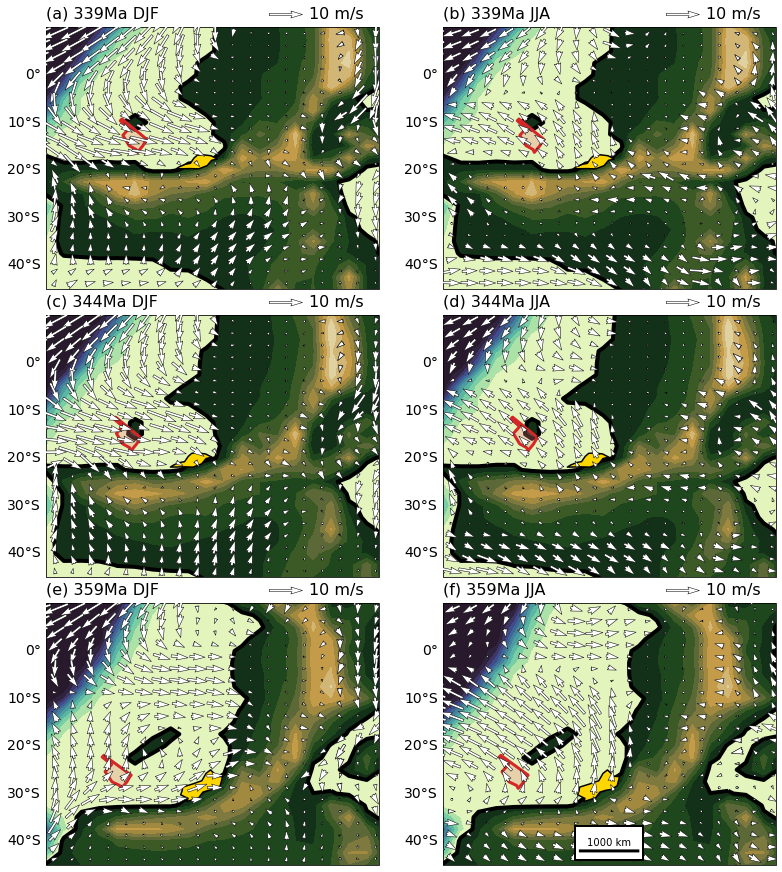

In [93]:
# loop over all models
# define figure layout first

exp_list_reduced  = ['teXpq', 'teXpr', 'teXpu']
labels_reduced    = ['339Ma', '344Ma', '359Ma']
panel_labels      = ['(a)', '(b)', '(c)','(d)', '(e)', '(f)']

fig, axes = plt.subplots(len(exp_list_reduced), 2, figsize=(11, 12), constrained_layout = True )
    
plotRow = 0
    
for expCount, exp in enumerate(exp_list_reduced):

    # load data
    modelHeight = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.modelHeight.nc', decode_times=False).modelHeight 
    latitude = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.modelHeight.nc', decode_times=False).latitude 
    longitude = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.modelHeight.nc', decode_times=False).longitude 

    lsm = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.mask.nc', decode_times=False).lsm [0,0,:,:]
    
    uwnd = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.pd.clim.nc', decode_times=False).u_mm_10m[:,0,:,:]
    vwnd = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.pd.clim.nc', decode_times=False).v_mm_10m[:,0,:,:] 
    latitudeV = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.pd.clim.nc', decode_times=False).latitude_1
    longitudeV = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.pd.clim.nc', decode_times=False).longitude_1
    
    pr = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.pd.clim.nc', decode_times=False).precip_mm_srf[:,0,:,:]*86400 

    # add cyclic longitude
    modelHeight_cyclic, longitude_cyclic = add_cyclic_point(modelHeight, coord=longitude)
    lsm_cyclic = add_cyclic_point(lsm)
    uwnd_cyclic,longitudeV_cyclic = add_cyclic_point(uwnd, coord=longitudeV)
    vwnd_cyclic = add_cyclic_point(vwnd)
    pr_cyclic = add_cyclic_point(pr)
    
    # DJF
    column = 0
    uwnd_DJF = uwnd_cyclic[[11,0,1],:,:].mean(axis=0)
    vwnd_DJF = vwnd_cyclic[[11,0,1],:,:].mean(axis=0)
    pr_DJF = pr_cyclic[[11,0,1],:,:].mean(axis=0)

    axes[expCount,column] = plt.subplot(len(exp_list_reduced), 2, plotRow * 2 + 1, projection=ccrs.PlateCarree())
    axes[expCount,column].set_extent([-60,10, -45,10], ccrs.PlateCarree())

    cf = axes[expCount,column].contourf(longitude_cyclic, latitude, modelHeight_cyclic, transform=ccrs.PlateCarree(),
                                        levels=21, vmin=-3000, vmax=3000, cmap=cmocean.cm.topo,
                                        add_colorbar=False,zorder=1, alpha=1.0 )
    
    cn = axes[expCount,column].contour(longitude_cyclic, latitude, modelHeight_cyclic, transform=ccrs.PlateCarree(),
                                    levels=[0.0], colors='black',zorder=1, linewidths=4.)
                                     
        
    #cp = axes[expCount,column].contour(longitude_cyclic, latitude, pr_DJF, transform=ccrs.PlateCarree(),levels = [0, 4, 8, 12], cmap='BuPu', linewidths=2., linestyles='solid', zorder=2)

    #axes[expCount,column].clabel(cp, cp.levels, inline=True, fontsize=8) 
    
    q = axes[expCount,column].quiver(longitudeV_cyclic, 
                                     latitudeV, 
                                     uwnd_DJF, 
                                     vwnd_DJF, 
                                     transform=ccrs.PlateCarree(), 
                                     zorder=3,
                                     scale = 100, width = 0.007, pivot='mid',
                                     edgecolor='k', linewidth=.5, facecolor='w')
    
    qk = axes[expCount,column].quiverkey(q, X=0.77, Y=1.05, U=10,
        label='10 m/s', labelpos='E')
    
    qk.text.set_fontsize(16)

    # Late Devonian Clastic Wedge: Time Slices 385 Ma – 359 Ma
    if exp == 'teXpz' or exp == 'teXpy' or exp == 'teXpx' or exp == 'teXpw' or exp == 'teXpv' or exp == 'teXpu':
        wedges_file = 'catskill-shape'
    # Price Pocono Clastic Wedge: Time Slices 354 Ma - 333 Ma
    elif exp == 'teXpt' or exp == 'teXps' or exp == 'teXpr' or exp == 'teXpq' or exp == 'teXpp':
        wedges_file = 'price-pocono-shape'
    # Pennington – Mauch Chunk: Time Slice 327 Ma
    elif exp == 'teXpn':
        wedges_file = 'pennington-shape'
        
#    axes[expCount,column].text(0.03, 0.97, labels_reduced[expCount] + ' DJF', transform=axes[expCount,column].transAxes, fontsize=20, fontweight='bold', va='top', ha='left', bbox=dict(facecolor='white', edgecolor='black', pad=3.0), zorder=5)
    #plotNum = 
    axes[expCount,column].text(0.0, 1.05, panel_labels[expCount*2 + 0] + ' ' + labels_reduced[expCount] + ' DJF', transform=axes[expCount,column].transAxes, fontsize=16, va='center', ha='left', zorder=5)  

    # plot wedges location 
    shp_info = shpreader.Reader(work_dir + '/reconstructions/' + labels_reduced[expCount] + '/' + wedges_file + '_' + labels_reduced[expCount] + '.shp').geometries()
    wedges  = cfeature.ShapelyFeature(shp_info, ccrs.PlateCarree())
    axes[expCount,column].add_feature(wedges, facecolor='gold', edgecolor='k', linewidth=1.5, alpha=1.0, zorder=2)
 
    # plot Oklahoma shape 
    shp_info = shpreader.Reader(work_dir + '/reconstructions/' + labels_reduced[expCount] + '/oklahoma-shape_' + labels_reduced[expCount] + '.shp').geometries()
    wedges  = cfeature.ShapelyFeature(shp_info, ccrs.PlateCarree())
    axes[expCount,column].add_feature(wedges, facecolor='lightcoral', edgecolor='none', alpha=0.3, zorder=2)
    axes[expCount,column].add_feature(wedges, facecolor='none', edgecolor='tab:red', linewidth=3.0, alpha=1., zorder=2)
    
    # gridlines
    gl = axes[expCount,column].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0., color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylabel_style = {'size': 14}

    # JJA
    column = 1
    uwnd_JJA = uwnd_cyclic[[5,6,7],:,:].mean(axis=0)
    vwnd_JJA = vwnd_cyclic[[5,6,7],:,:].mean(axis=0)
    pr_JJA = pr_cyclic[[5,6,7],:,:].mean(axis=0)

    axes[expCount,column] = plt.subplot(len(exp_list_reduced), 2, plotRow * 2 + 2, projection=ccrs.PlateCarree())
    axes[expCount,column].set_extent([-60,10, -45,10], ccrs.PlateCarree())

    cf = axes[expCount,column].contourf(longitude_cyclic, latitude, modelHeight_cyclic, transform=ccrs.PlateCarree(),
                                        levels=21, vmin=-3000, vmax=3000, cmap=cmocean.cm.topo,
                                        add_colorbar=False,zorder=1, alpha=1.0 )

      
    cn = axes[expCount,column].contour(longitude_cyclic, latitude, modelHeight_cyclic, transform=ccrs.PlateCarree(),
        levels=[0.0], colors='black',zorder=1, linewidths=4.)
    
    #cp = axes[expCount,column].contour(longitude_cyclic, latitude, pr_JJA, transform=ccrs.PlateCarree(),levels = [0, 4, 8, 12], cmap='BuPu', linewidths=2.0, linestyles='solid', zorder=2)

    #axes[expCount,column].clabel(cp, cp.levels, inline=True, fontsize=8) 
    
    q = axes[expCount,column].quiver(longitudeV_cyclic, 
                                     latitudeV, 
                                     uwnd_JJA, 
                                     vwnd_JJA, 
                                     transform=ccrs.PlateCarree(), 
                                     zorder=3,
                                     scale = 100, width = 0.007, pivot='mid',
                                     edgecolor='k', linewidth=.5, facecolor='w')

    qk = axes[expCount,column].quiverkey(q, X=0.77, Y=1.05, U=10,
        label='10 m/s', labelpos='E')
    
    qk.text.set_fontsize(16)

#    axes[expCount,column].text(0.03, 0.97, labels_reduced[expCount] + ' JJA', transform=axes[expCount,column].transAxes, fontsize=20, fontweight='bold', va='top', ha='left', bbox=dict(facecolor='white', edgecolor='black', pad=3.0), zorder=5)
    axes[expCount,column].text(0.0, 1.05, panel_labels[expCount*2 + 1] + ' ' + labels_reduced[expCount] + ' JJA', transform=axes[expCount,column].transAxes, fontsize=16, va='center', ha='left', zorder=5)  

    # plot wedges location 
    shp_info = shpreader.Reader(work_dir + '/reconstructions/' + labels_reduced[expCount] + '/' + wedges_file + '_' + labels_reduced[expCount] + '.shp').geometries()
    wedges  = cfeature.ShapelyFeature(shp_info, ccrs.PlateCarree())
    axes[expCount,column].add_feature(wedges, facecolor='gold', edgecolor='k', linewidth=1.5, alpha=1.0, zorder=2)
    
    # plot Oklahoma shape 
    shp_info = shpreader.Reader(work_dir + '/reconstructions/' + labels_reduced[expCount] + '/oklahoma-shape_' + labels_reduced[expCount] + '.shp').geometries()
    wedges  = cfeature.ShapelyFeature(shp_info, ccrs.PlateCarree())
    axes[expCount,column].add_feature(wedges, facecolor='lightcoral', edgecolor='none', alpha=0.3, zorder=2)
    axes[expCount,column].add_feature(wedges, facecolor='none', edgecolor='tab:red', linewidth=3.0, alpha=1., zorder=2)

    if expCount == len(exp_list_reduced)-1:
        scale_bar(axes[expCount,column], 1000, location=(0.5, 0.135))

    # gridlines
    gl = axes[expCount,column].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=.0, color='gray', alpha=0.5, linestyle='solid')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylabel_style = {'size': 14}

    plotRow += 1
        


if save_figures:
    plt.savefig(work_dir + '/figures/Devono-Mississippian-winds-NA_main.pdf')


### Figure 2: Seasonsal winds and precipitation for all time periods (for SI)

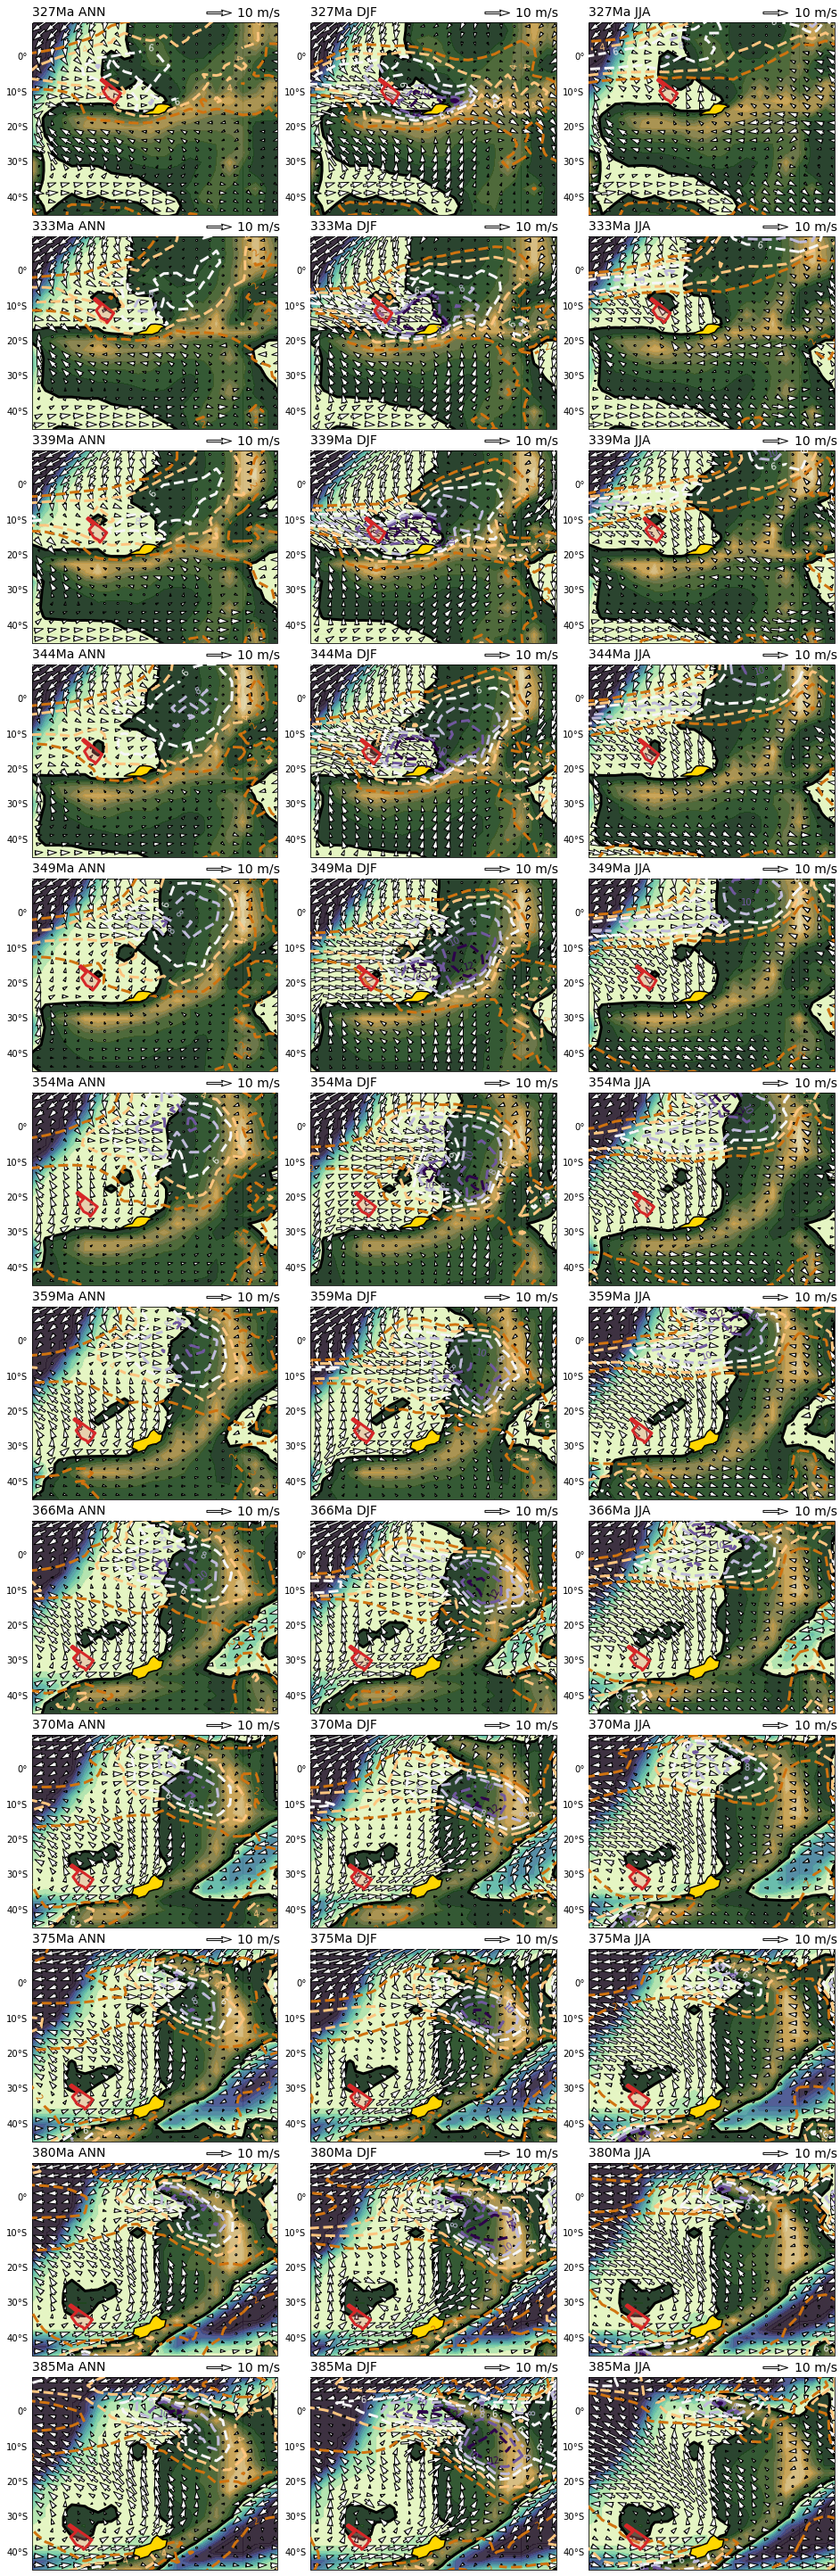

In [102]:
exp_list = np.flip(['teXpz', 'teXpy', 'teXpx', 'teXpw', 'teXpv', 'teXpu', 'teXpt', 'teXps', 'teXpr', 'teXpq', 'teXpp', 'teXpn']) # list of data sets to loop over
labels   = np.flip(['385Ma', '380Ma', '375Ma', '370Ma', '366Ma', '359Ma', '354Ma', '349Ma', '344Ma', '339Ma', '333Ma', '327Ma']) # list of associated ages for labeling

# loop over all models
# define figure layout first
fig, axes = plt.subplots(len(exp_list), 3, figsize=(13, 40), constrained_layout = True )
    
plotRow = 0
    
for expCount, exp in enumerate(exp_list):

    # load data
    modelHeight = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.modelHeight.nc', decode_times=False).modelHeight 
    latitude = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.modelHeight.nc', decode_times=False).latitude 
    longitude = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.modelHeight.nc', decode_times=False).longitude 

    lsm = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.mask.nc', decode_times=False).lsm [0,0,:,:]
    
    uwnd = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.pd.clim.nc', decode_times=False).u_mm_10m[:,0,:,:]
    vwnd = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.pd.clim.nc', decode_times=False).v_mm_10m[:,0,:,:] 
    latitudeV = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.pd.clim.nc', decode_times=False).latitude_1
    longitudeV = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.pd.clim.nc', decode_times=False).longitude_1
    
    pr = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.pd.clim.nc', decode_times=False).precip_mm_srf[:,0,:,:]*86400 

    # add cyclic longitude
    modelHeight_cyclic, longitude_cyclic = add_cyclic_point(modelHeight, coord=longitude)
    lsm_cyclic = add_cyclic_point(lsm)
    uwnd_cyclic,longitudeV_cyclic = add_cyclic_point(uwnd, coord=longitudeV)
    vwnd_cyclic = add_cyclic_point(vwnd)
    pr_cyclic = add_cyclic_point(pr)

    # annual mean data
    column = 0
    uwnd_ym = uwnd_cyclic.mean(axis=0)
    vwnd_ym = vwnd_cyclic.mean(axis=0)
    pr_ym = pr_cyclic.mean(axis=0)

    axes[expCount,column] = plt.subplot(len(exp_list), 3, plotRow * 3 + 1, projection=ccrs.PlateCarree())
    axes[expCount,column].set_extent([-60,10, -45,10], ccrs.PlateCarree())

    cf = axes[expCount,column].contourf(longitude_cyclic, latitude, modelHeight_cyclic, transform=ccrs.PlateCarree(),
                                        levels=21, vmin=-3000, vmax=3000, cmap=cmocean.cm.topo,
                                        add_colorbar=False,zorder=1, alpha=0.9 )
    # precip
    cn = axes[expCount,column].contour(longitude_cyclic, latitude, pr_ym, transform=ccrs.PlateCarree(),levels = [0, 2, 4, 6, 8, 10, 12], cmap='PuOr', linewidths=3, linestyles='dashed', zorder=4)
    axes[expCount,column].clabel(cn, cn.levels, inline=True, fontsize=10) 

    # coastline
    cn = axes[expCount,column].contour(longitude_cyclic, latitude, modelHeight_cyclic, transform=ccrs.PlateCarree(),levels=[0.0], colors='black',zorder=1, linewidths=3.) 

    q = axes[expCount,column].quiver(longitudeV_cyclic, 
                                     latitudeV, 
                                     uwnd_ym, 
                                     vwnd_ym, 
                                     transform=ccrs.PlateCarree(), 
                                     zorder=3,
                                     scale = 100, width = 0.008, pivot='mid',
                                     edgecolor='k', linewidth=1., facecolor='w')
    
    qk = axes[expCount,column].quiverkey(q, X=0.81, Y=1.05, U=10,
        label='10 m/s', labelpos='E')
    
    qk.text.set_fontsize(14)

#    axes[expCount,column].text(0.03, 0.97, labels[expCount] + ' ANN', transform=axes[expCount,column].transAxes, fontsize=20, fontweight='bold', va='top', ha='left', bbox=dict(facecolor='white', edgecolor='black', pad=3.0), zorder=5)
    axes[expCount,column].text(0.0, 1.05, labels[expCount] + ' ANN', transform=axes[expCount,column].transAxes, fontsize=14, va='center', ha='left', zorder=5)

    # Late Devonian Clastic Wedge: Time Slices 385 Ma – 359 Ma
    if exp == 'teXpz' or exp == 'teXpy' or exp == 'teXpx' or exp == 'teXpw' or exp == 'teXpv' or exp == 'teXpu':
        wedges_file = 'catskill-shape'
    # Price Pocono Clastic Wedge: Time Slices 354 Ma - 333 Ma
    elif exp == 'teXpt' or exp == 'teXps' or exp == 'teXpr' or exp == 'teXpq' or exp == 'teXpp' or exp == 'teXpn':
        wedges_file = 'price-pocono-shape'
    # Pennington – Mauch Chunk: Time Slice 327 Ma
    # elif exp == 'teXpn':
    #     wedges_file = 'pennington-shape'
        
    # plot wedges location 
    shp_info = shpreader.Reader(work_dir + '/reconstructions/' + labels[expCount] + '/' + wedges_file + '_' + labels[expCount] + '.shp').geometries()
    wedges  = cfeature.ShapelyFeature(shp_info, ccrs.PlateCarree())
    axes[expCount,column].add_feature(wedges, facecolor='gold', edgecolor='k', linewidth=1.5, alpha=1.0, zorder=5)
    
    # plot Oklahoma shape 
    shp_info = shpreader.Reader(work_dir + '/reconstructions/' + labels[expCount] + '/oklahoma-shape_' + labels[expCount] + '.shp').geometries()
    wedges  = cfeature.ShapelyFeature(shp_info, ccrs.PlateCarree())
    axes[expCount,column].add_feature(wedges, facecolor='lightcoral', edgecolor='none', alpha=0.3, zorder=5)
    axes[expCount,column].add_feature(wedges, facecolor='none', edgecolor='tab:red', linewidth=3.0, alpha=1., zorder=5)
    
    # gridlines
    gl = axes[expCount,column].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0., color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    gl.xlines = False
    
    # DJF
    column = 1
    uwnd_DJF = uwnd_cyclic[[11,0,1],:,:].mean(axis=0)
    vwnd_DJF = vwnd_cyclic[[11,0,1],:,:].mean(axis=0)
    pr_DJF = pr_cyclic[[11,0,1],:,:].mean(axis=0)

    axes[expCount,column] = plt.subplot(len(exp_list), 3, plotRow * 3 + 2, projection=ccrs.PlateCarree())
    axes[expCount,column].set_extent([-60,10, -45,10], ccrs.PlateCarree())

    cf = axes[expCount,column].contourf(longitude_cyclic, latitude, modelHeight_cyclic, transform=ccrs.PlateCarree(),
                                        levels=21, vmin=-3000, vmax=3000, cmap=cmocean.cm.topo,
                                        add_colorbar=False,zorder=1, alpha=0.9 )
    cn = axes[expCount,column].contour(longitude_cyclic, latitude, pr_DJF, transform=ccrs.PlateCarree(),levels = [0, 2, 4, 6, 8, 10, 12], cmap='PuOr', linewidths=3, linestyles='dashed', zorder=4)
    axes[expCount,column].clabel(cn, cn.levels, inline=True, fontsize=10) 

    # coastline
    cn = axes[expCount,column].contour(longitude_cyclic, latitude, modelHeight_cyclic, transform=ccrs.PlateCarree(),levels=[0.0], colors='black',zorder=1, linewidths=3.)  
    
    q = axes[expCount,column].quiver(longitudeV_cyclic, 
                                     latitudeV, 
                                     uwnd_DJF, 
                                     vwnd_DJF, 
                                     transform=ccrs.PlateCarree(), 
                                     zorder=3,
                                     scale = 100, width = 0.008, pivot='mid',
                                     edgecolor='k', linewidth=1., facecolor='w')

    qk = axes[expCount,column].quiverkey(q, X=0.81, Y=1.05, U=10,
        label='10 m/s', labelpos='E')
    
    qk.text.set_fontsize(14)

#    axes[expCount,column].text(0.03, 0.97, labels[expCount] + ' DJF', transform=axes[expCount,column].transAxes, fontsize=20, fontweight='bold', va='top', ha='left', bbox=dict(facecolor='white', edgecolor='black', pad=3.0), zorder=5)
    axes[expCount,column].text(0.0, 1.05, labels[expCount] + ' DJF', transform=axes[expCount,column].transAxes, fontsize=14, va='center', ha='left', zorder=5)

    # plot wedges location 
    shp_info = shpreader.Reader(work_dir + '/reconstructions/' + labels[expCount] + '/' + wedges_file + '_' + labels[expCount] + '.shp').geometries()
    wedges  = cfeature.ShapelyFeature(shp_info, ccrs.PlateCarree())
    axes[expCount,column].add_feature(wedges, facecolor='gold', edgecolor='k', linewidth=1.5, alpha=1.0, zorder=5)
    
    # plot Oklahoma shape 
    shp_info = shpreader.Reader(work_dir + '/reconstructions/' + labels[expCount] + '/oklahoma-shape_' + labels[expCount] + '.shp').geometries()
    wedges  = cfeature.ShapelyFeature(shp_info, ccrs.PlateCarree())
    axes[expCount,column].add_feature(wedges, facecolor='lightcoral', edgecolor='none', alpha=0.3, zorder=5)
    axes[expCount,column].add_feature(wedges, facecolor='none', edgecolor='tab:red', linewidth=3.0, alpha=1., zorder=5)
    
    # gridlines
    gl = axes[expCount,column].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0., color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    gl.xlines = False

    # JJA
    column = 2
    uwnd_JJA = uwnd_cyclic[[5,6,7],:,:].mean(axis=0)
    vwnd_JJA = vwnd_cyclic[[5,6,7],:,:].mean(axis=0)
    pr_JJA = pr_cyclic[[5,6,7],:,:].mean(axis=0)

    axes[expCount,column] = plt.subplot(len(exp_list), 3, plotRow * 3 + 3, projection=ccrs.PlateCarree())
    axes[expCount,column].set_extent([-60,10, -45,10], ccrs.PlateCarree())

    cf = axes[expCount,column].contourf(longitude_cyclic, latitude, modelHeight_cyclic, transform=ccrs.PlateCarree(),
                                        levels=21, vmin=-3000, vmax=3000, cmap=cmocean.cm.topo,
                                        add_colorbar=False,zorder=1, alpha=0.9 )
    cn = axes[expCount,column].contour(longitude_cyclic, latitude, pr_JJA, transform=ccrs.PlateCarree(),levels = [0, 2, 4, 6, 8, 10, 12], cmap='PuOr', linewidths=3, linestyles='dashed', zorder=4)

    axes[expCount,column].clabel(cn, cn.levels, inline=True, fontsize=10) 

    # coastline
    cn = axes[expCount,column].contour(longitude_cyclic, latitude, modelHeight_cyclic, transform=ccrs.PlateCarree(),levels=[0.0], colors='black',zorder=1, linewidths=3.) 
    
    q = axes[expCount,column].quiver(longitudeV_cyclic, 
                                     latitudeV, 
                                     uwnd_JJA, 
                                     vwnd_JJA, 
                                     transform=ccrs.PlateCarree(), 
                                     zorder=3,
                                     scale = 100, width = 0.008, pivot='mid',
                                     edgecolor='k', linewidth=1., facecolor='w')

    qk = axes[expCount,column].quiverkey(q, X=0.81, Y=1.05, U=10,
        label='10 m/s', labelpos='E')
    
    qk.text.set_fontsize(14)

#    axes[expCount,column].text(0.03, 0.97, labels[expCount] + ' JJA', transform=axes[expCount,column].transAxes, fontsize=20, fontweight='bold', va='top', ha='left', bbox=dict(facecolor='white', edgecolor='black', pad=3.0), zorder=5)
    axes[expCount,column].text(0.0, 1.05, labels[expCount] + ' JJA', transform=axes[expCount,column].transAxes, fontsize=14, va='center', ha='left', zorder=5)

    # plot wedges location 
    shp_info = shpreader.Reader(work_dir + '/reconstructions/' + labels[expCount] + '/' + wedges_file + '_' + labels[expCount] + '.shp').geometries()
    wedges  = cfeature.ShapelyFeature(shp_info, ccrs.PlateCarree())
    axes[expCount,column].add_feature(wedges, facecolor='gold', edgecolor='k', linewidth=1.5, alpha=1.0, zorder=5)
    
    # plot Oklahoma shape 
    shp_info = shpreader.Reader(work_dir + '/reconstructions/' + labels[expCount] + '/oklahoma-shape_' + labels[expCount] + '.shp').geometries()
    wedges  = cfeature.ShapelyFeature(shp_info, ccrs.PlateCarree())
    axes[expCount,column].add_feature(wedges, facecolor='lightcoral', edgecolor='none', alpha=0.3, zorder=5)
    axes[expCount,column].add_feature(wedges, facecolor='none', edgecolor='tab:red', linewidth=3.0, alpha=1., zorder=5)
    
    # gridlines
    gl = axes[expCount,column].gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0., color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    gl.xlines = False

    plotRow += 1
        
if save_figures:
    plt.savefig(work_dir + '/figures/Devono-Mississippian-winds-NA_supplements.jpg', dpi=200)


In [ ]:
### Figure 3: Global paleogeography maps (for SI)

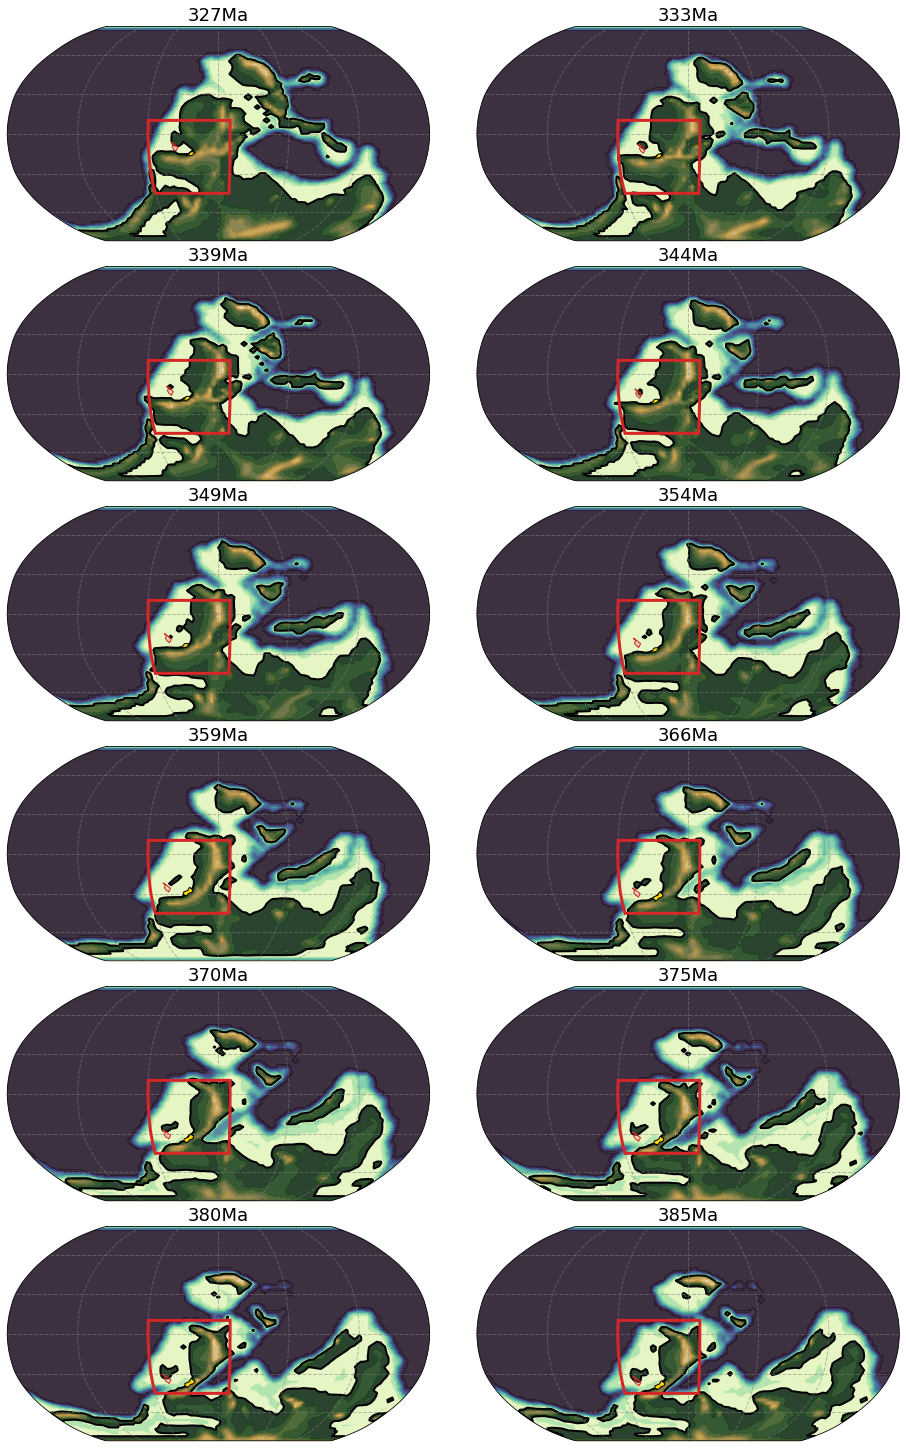

In [101]:
exp_list = np.flip(['teXpz', 'teXpy', 'teXpx', 'teXpw', 'teXpv', 'teXpu', 'teXpt', 'teXps', 'teXpr', 'teXpq', 'teXpp', 'teXpn']) # list of data sets to loop over
labels   = np.flip(['385Ma', '380Ma', '375Ma', '370Ma', '366Ma', '359Ma', '354Ma', '349Ma', '344Ma', '339Ma', '333Ma', '327Ma']) # list of associated ages for labeling

# loop over all models
# define figure layout first
fig, axes = plt.subplots(6, 2, figsize=(13, 20), constrained_layout = True )

row = 0.
for expCount, exp in enumerate(exp_list):
    
    column = expCount%2

    # load data
    modelHeight = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.modelHeight.nc', decode_times=False).modelHeight 
    latitude = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.modelHeight.nc', decode_times=False).latitude 
    longitude = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.modelHeight.nc', decode_times=False).longitude 

    lsm = xr.open_dataset(data_dir + 'HadCM3BL/' + exp + '.mask.nc', decode_times=False).lsm [0,0,:,:]
    
    # add cyclic longitude
    modelHeight_cyclic, longitude_cyclic = add_cyclic_point(modelHeight, coord=longitude)
    lsm_cyclic = add_cyclic_point(lsm)

    axes[int(row),column] = plt.subplot(6, 2, expCount+1, projection=ccrs.Robinson())
    axes[int(row),column].set_global()

    cf = axes[int(row),column].contourf(longitude_cyclic, latitude, modelHeight_cyclic, transform=ccrs.PlateCarree(),
                                        levels=21, vmin=-3000, vmax=3000, cmap=cmocean.cm.topo,
                                        add_colorbar=False,zorder=1, alpha=0.9 )

    # coastline
    cn = axes[int(row),column].contour(longitude_cyclic, latitude, modelHeight_cyclic, transform=ccrs.PlateCarree(),levels=[0.0], colors='black',zorder=1, linewidths=2.0)  

    axes[int(row),column].text(0.5, 1.05, labels[expCount], transform=axes[int(row),column].transAxes, fontsize=18, va='center', ha='center', zorder=5)
 
    # Late Devonian Clastic Wedge: Time Slices 385 Ma – 359 Ma
    if exp == 'teXpz' or exp == 'teXpy' or exp == 'teXpx' or exp == 'teXpw' or exp == 'teXpv' or exp == 'teXpu':
        wedges_file = 'catskill-shape'
    # Price Pocono Clastic Wedge: Time Slices 354 Ma - 333 Ma
    elif exp == 'teXpt' or exp == 'teXps' or exp == 'teXpr' or exp == 'teXpq' or exp == 'teXpp' or exp == 'teXpn':
        wedges_file = 'price-pocono-shape'
    # Pennington – Mauch Chunk: Time Slice 327 Ma
    # elif exp == 'teXpn':
    #     wedges_file = 'pennington-shape'
        
    # plot wedges location 
    shp_info = shpreader.Reader(work_dir + '/reconstructions/' + labels[expCount] + '/' + wedges_file + '_' + labels[expCount] + '.shp').geometries()
    wedges  = cfeature.ShapelyFeature(shp_info, ccrs.PlateCarree())
    axes[int(row),column].add_feature(wedges, facecolor='gold', edgecolor='k', linewidth=1.0, alpha=1.0, zorder=5)
    
    # plot Oklahoma shape 
    shp_info = shpreader.Reader(work_dir + '/reconstructions/' + labels[expCount] + '/oklahoma-shape_' + labels[expCount] + '.shp').geometries()
    wedges  = cfeature.ShapelyFeature(shp_info, ccrs.PlateCarree())
    axes[int(row),column].add_feature(wedges, facecolor='lightcoral', edgecolor='none', alpha=0.3, zorder=5)
    axes[int(row),column].add_feature(wedges, facecolor='none', edgecolor='tab:red', linewidth=1.0, alpha=1., zorder=5)
    
    axes[int(row),column].add_patch(mpatches.Rectangle(xy=[-60, -45], width=70, height=55,
                                facecolor='none',
                                edgecolor='tab:red',
                                linewidth=3.0,
                                alpha=1.0,
                                linestyle='-',
                                zorder=5,
                                transform=ccrs.PlateCarree())
             )
    

    # gridlines
    gl = axes[int(expCount/2.),column].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1., color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.bottom_labels = False
    gl.right_labels = False
    gl.xlines = True
    
    row += 0.5
            
if save_figures:
     #plt.savefig(work_dir + '/figures/Devono-Mississippian-global-geographys.jpg', dpi=200)
    plt.savefig(work_dir + '/figures/Devono-Mississippian-global-geographys.pdf')
